<a href="https://colab.research.google.com/github/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim_LHCb_templates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making histograms for use in a binned fit

In the last notebook, we learned how to calculate weights which help us project out template shapes for each term in our angular decay rate. In this notebook, we use some cutting-edge histogramming tools in Python (the `hist` package) to create histograms which can be used in a `zfit` binned fit.

In [1]:
!pip install uproot
!pip install tensorflow==2.6.2 #specific versions for compatability with zfit
!pip install hist
!pip install mplhep
!pip install zfit
!pip install uncertainties

In [43]:
import uproot
import numpy as np
import tensorflow as tf
import zfit
import hist
from hist import Hist
import mplhep
import pandas as pd
import pickle

In [6]:
#Load ROOT file
drive_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files"
file_path = f"{drive_dir}/Bc2JpsiMuNu_RapidSim_LHCb_Vars_Weights"
print(f"Loading ROOT file {file_path}.root")
tree_name = "DecayTree"
events = uproot.open(f"{file_path}.root:{tree_name}")
events

Loading ROOT file /content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files/Bc2JpsiMuNu_RapidSim_LHCb_Vars_Weights.root


<TTree 'DecayTree' (172 branches) at 0x7fe4aab21dd0>

In [7]:
#Make pandas DataFrame
df = events.arrays(library="pd")

Let's make a 1D histogram of the reconstructed $\cos(\theta_{J/\psi})$, with 100 bins and a range from -1 to +1:

In [8]:
#Define a histogram object
h = Hist(hist.axis.Regular(bins=100, start=-1., stop=1., name="costheta_Jpsi"))
#Fill our hist with the variable of interest, taking values from our DataFrame
h.fill(df["costheta_Jpsi_reco"])

Hist(Regular(100, -1, 1, name='costheta_Jpsi', label='costheta_Jpsi'), storage=Double()) # Sum: 912284.0

We can use the `mplhep` (matplotlib for high energy physics) package to quickly plot our hist:

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe46cfd7510>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

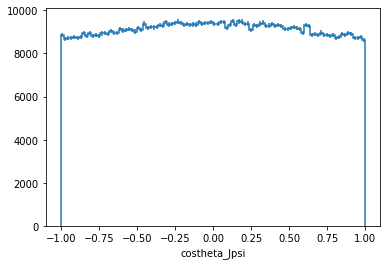

In [11]:
mplhep.histplot(h)

We can also make histograms with weights applied, which will be important for the purposes of our fit. To do this, we supply a weight column of our DataFrame to the `fill()` funcion.

In [16]:
#A histogram of costheta_Jpsi_reco with weight applied for term 1 in the angular fit
h_1 = (
     Hist.new
    .Regular(100, -1., 1., name="costheta_Jpsi_reco_1")
    .Weight()
)

In [17]:
h_1.fill(df["costheta_Jpsi_reco"], weight=df["weight_1"])

Hist(Regular(100, -1, 1, name='costheta_Jpsi_reco_1', label='costheta_Jpsi_reco_1'), storage=Weight()) # Sum: WeightedSum(value=944039, variance=3.25513e+06)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe464499810>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

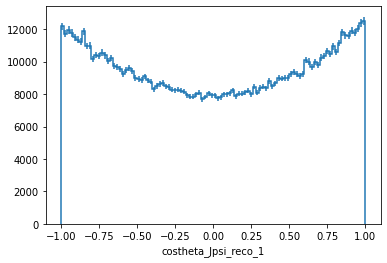

In [18]:
mplhep.histplot(h_1)

We aren't limited to 1D histograms either! We can make a histogram with any number of dimensions using `Hist`. In this analysis, we'll want to fit the 3D angular distribution. So we can try to make a 3D histogram.

In [19]:
#3D histogram in all three decay angles with weights applied for term 0
#10 bins in each angle = 10^3 = 1000 bins in total
hist3D_0 = (
     Hist.new
    .Regular(10, -1., 1., name="costheta_Jpsi")
    .Regular(10, -1., 1., name="costheta_W")
    .Regular(10, -np.pi, np.pi, name="chi")
    .Weight()
)

In [23]:
hist3D_0.fill(df["costheta_Jpsi_reco"], df["costheta_W_reco"], df["chi_reco"], weight=df["weight_0"])

Hist(
  Regular(10, -1, 1, name='costheta_Jpsi', label='costheta_Jpsi'),
  Regular(10, -1, 1, name='costheta_W', label='costheta_W'),
  Regular(10, -3.14159, 3.14159, name='chi', label='chi'),
  storage=Weight()) # Sum: WeightedSum(value=907913, variance=1.17846e+06) (WeightedSum(value=909000, variance=1.17989e+06) with flow)

It can be useful to keep sets of useful objects, like histograms, in a dictionary. Then we can access them via their `key` (the name we give them inside square brackets) in the dictionary at a later stage.

Here we loop over the 6 angular terms we have, making histograms for each angular term. Notice that we are using our `weight_{0..5}` branches here, to apply the corresponding weights for each angular term.

In [24]:
#Make histograms for each angular term
all_h = {}

for i in range(0,6):
  all_h[i] = (
      Hist.new
      .Regular(10, -1., 1., name="costheta_Jpsi")
      .Regular(10, -1., 1., name="costheta_W")
      .Regular(10, -np.pi, np.pi, name="chi")
      .Weight()
  )
  all_h[i].fill(df["costheta_Jpsi_reco"], df["costheta_W_reco"], df["chi_reco"], weight=df[f"weight_{i}"])

In [25]:
all_h

{0: Hist(
   Regular(10, -1, 1, name='costheta_Jpsi', label='costheta_Jpsi'),
   Regular(10, -1, 1, name='costheta_W', label='costheta_W'),
   Regular(10, -3.14159, 3.14159, name='chi', label='chi'),
   storage=Weight()) # Sum: WeightedSum(value=907913, variance=1.17846e+06) (WeightedSum(value=909000, variance=1.17989e+06) with flow),
 1: Hist(
   Regular(10, -1, 1, name='costheta_Jpsi', label='costheta_Jpsi'),
   Regular(10, -1, 1, name='costheta_W', label='costheta_W'),
   Regular(10, -3.14159, 3.14159, name='chi', label='chi'),
   storage=Weight()) # Sum: WeightedSum(value=941657, variance=3.24465e+06) (WeightedSum(value=944039, variance=3.25513e+06) with flow),
 2: Hist(
   Regular(10, -1, 1, name='costheta_Jpsi', label='costheta_Jpsi'),
   Regular(10, -1, 1, name='costheta_W', label='costheta_W'),
   Regular(10, -3.14159, 3.14159, name='chi', label='chi'),
   storage=Weight()) # Sum: WeightedSum(value=904266, variance=1.41156e+06) (WeightedSum(value=904749, variance=1.41217e+06) w

We can also be a bit smarter and define a general dictionary of variables. Inside this, we can put names for our x, y, and z variables, number of bins, min and max values, and a LaTeX name for plotting.

In [37]:
vars = {}
vars["x_var"] = {"name": "costheta_Jpsi_reco", "min": -1., "max": 1., "bins": 10, "latex": "$\\cos(\\theta_{J/\\psi})$"}
vars["y_var"] = {"name": "costheta_W_reco", "min": -1., "max": 1., "bins": 10, "latex": "$\\cos(\\theta_{W})$"}
vars["z_var"] = {"name": "chi_reco", "min": -np.pi, "max": np.pi, "bins": 10, "latex": "$\\chi$ [rad]"}
vars

{'x_var': {'bins': 10,
  'latex': '$\\cos(\\theta_{J/\\psi})$',
  'max': 1.0,
  'min': -1.0,
  'name': 'costheta_Jpsi_reco'},
 'y_var': {'bins': 10,
  'latex': '$\\cos(\\theta_{W})$',
  'max': 1.0,
  'min': -1.0,
  'name': 'costheta_W_reco'},
 'z_var': {'bins': 10,
  'latex': '$\\chi$ [rad]',
  'max': 3.141592653589793,
  'min': -3.141592653589793,
  'name': 'chi_reco'}}

Now we can use values from this `vars` dictionary when making our set of histograms:

In [28]:
all_h = {}

#Loop over each of our angular decay rate terms 
for i in range(0,6):
  all_h[i] = (
      Hist.new
      .Regular(vars["x_var"]["bins"], vars["x_var"]["min"], vars["x_var"]["max"], name=vars["x_var"]["name"])
      .Regular(vars["y_var"]["bins"], vars["y_var"]["min"], vars["y_var"]["max"], name=vars["y_var"]["name"])
      .Regular(vars["z_var"]["bins"], vars["z_var"]["min"], vars["z_var"]["max"], name=vars["z_var"]["name"])
      .Weight()
  )
  all_h[i].fill(df[vars["x_var"]["name"]], 
                df[vars["y_var"]["name"]], 
                df[vars["z_var"]["name"]], 
                weight=df[f"weight_{i}"])

So far we have made histograms that have equal width bins. It is also possible to make histograms where you pass in a list of the bin edges. One useful binning scheme is to place equal numbers of events into each bin. We can make use of the `qcut` functionality in `pandas` to help us do this.

In [32]:
#Above binning schemes have equal width bins - we can also make binnings that have equal events per bin 
def get_binning(df):
  
  qc_bin_vals = {}

  for v in vars:
    qc = pd.qcut(df[vars[v]["name"]], q=vars[v]["bins"], precision=5)
    qc_bins = qc.unique()
    qc_bin_vals[v] = []
    for j in range(0,vars[v]["bins"]):
      qc_bin_vals[v].append(qc_bins[j].left)
      qc_bin_vals[v].append(qc_bins[j].right)
    #Retain unique values then sort
    qc_bin_vals[v] = list(set(qc_bin_vals[v]))
    qc_bin_vals[v].sort()

    qc_bin_vals[v][0] = vars[v]["min"]
    qc_bin_vals[v][-1] = vars[v]["max"]

    print(f"Binning for {vars[v]['name']}: {qc_bin_vals[v]}")

  return qc_bin_vals

In [34]:
binnings = get_binning(df)

Binning for costheta_Jpsi_reco: [-1.0, -0.79216, -0.58822, -0.38891, -0.19395, 0.00055617, 0.19486, 0.39035, 0.5888, 0.79242, 1.0]
Binning for costheta_W_reco: [-1.0, -0.46394, -0.12545, 0.13095, 0.33459, 0.50304, 0.64358, 0.76183, 0.861, 0.94157, 1.0]
Binning for chi_reco: [-3.141592653589793, -2.42962, -1.84089, -1.30021, -0.71122, 0.0043844, 0.71329, 1.29936, 1.83985, 2.42724, 3.141592653589793]


In [38]:
binnings

{'x_var': [-1.0,
  -0.79216,
  -0.58822,
  -0.38891,
  -0.19395,
  0.00055617,
  0.19486,
  0.39035,
  0.5888,
  0.79242,
  1.0],
 'y_var': [-1.0,
  -0.46394,
  -0.12545,
  0.13095,
  0.33459,
  0.50304,
  0.64358,
  0.76183,
  0.861,
  0.94157,
  1.0],
 'z_var': [-3.141592653589793,
  -2.42962,
  -1.84089,
  -1.30021,
  -0.71122,
  0.0043844,
  0.71329,
  1.29936,
  1.83985,
  2.42724,
  3.141592653589793]}

Now we can use the values from our `binnings` dictionary to make a set of histograms with our new non-uniform binning scheme.

In [36]:
all_h = {}

#Loop over each of our angular decay rate terms 
for i in range(0,6):
  all_h[i] = (
      Hist.new
      .Variable(binnings["x_var"], name=vars["x_var"]["name"])
      .Variable(binnings["y_var"], name=vars["y_var"]["name"])
      .Variable(binnings["z_var"], name=vars["z_var"]["name"])
      .Weight()
  )
  all_h[i].fill(df[vars["x_var"]["name"]], 
                df[vars["y_var"]["name"]], 
                df[vars["z_var"]["name"]], 
                weight=df[f"weight_{i}"])

One final step to prepare our histograms for use as fit templates is to normalise them all. We do this by calculating the sum of all bins in the first histogram we make, and then dividing all of the histograms by that same sum. 

In [42]:
norm = None

all_h_norm = {}

for i in range(0,6):
  if not norm:
    norm = np.sum(all_h[i].values())
    print(f"Normalisation: {norm}")
  all_h_norm[i] = all_h[i] / norm

Normalisation: 907912.7872448382


Let's save our histograms for use in future analysis. We can store them in a pickle file:

In [45]:
hist_path = "/content/drive/MyDrive/Bc2JpsiMuNu_Analysis/pickle"
for h in all_h_norm:  
  with open(f"{hist_path}/hist_{h}.pkl", "wb") as f:
    pickle.dump(all_h_norm[h], f)

We have now created 3D histogram templates for each term in our angular decay rate. The histograms are defined in our reconstructed angular variable space, which is the space that a real data analysis would operate in (we don't have access to the true angles in real data!). We will want to use these templates to try and perform a fit to the 3D reconstructed angular distribution, in order to measure the helicity amplitudes. This fit will be the binned equivalent of the fit we did to the truth-level angles in our earlier zfit notebook.